In [ ]:
!unzip "/content/Potato.zip"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Potato',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

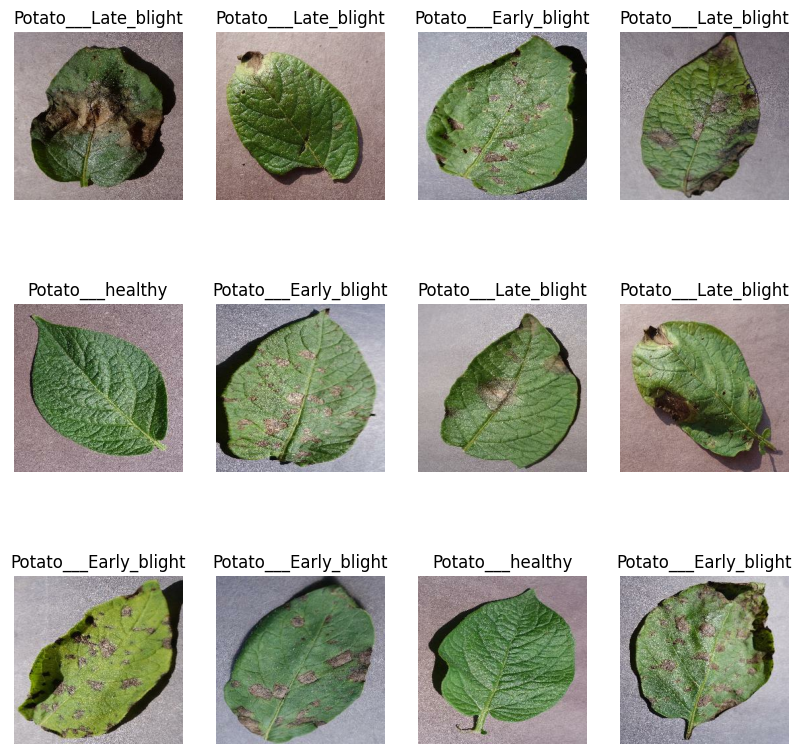

In [7]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [8]:
def get_data_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

print(len(dataset))
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

68
54
6
8


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 17s 119ms/step - loss: 0.9202 - accuracy: 0.4873 - val_loss: 0.8795 - val_accuracy: 0.7552
Epoch 2/50
54/54 [==============================] - 3s 58ms/step - loss: 0.8524 - accuracy: 0.5694 - val_loss: 0.7156 - val_accuracy: 0.7135
Epoch 3/50
54/54 [==============================] - 3s 57ms/step - loss: 0.5700 - accuracy: 0.7679 - val_loss: 0.4128 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 3s 58ms/step - loss: 0.4107 - accuracy: 0.8385 - val_loss: 0.3678 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3416 - accuracy: 0.8617 - val_loss: 0.3818 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 3s 57ms/step - loss: 0.3006 - accuracy: 0.8843 - val_loss: 0.2992 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2794 - accuracy: 0.8854 - val_loss: 0.3678 - val_accuracy: 0.8542
Epoch 8/50


In [17]:
score = model.evaluate(test_ds)

8/8 [==============================] - 2s 27ms/step - loss: 0.0635 - accuracy: 0.9688


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

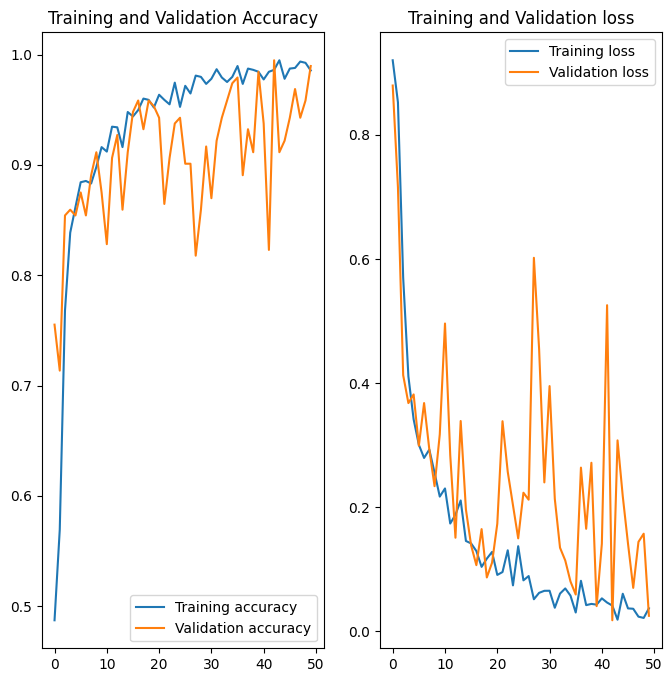

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

First image to predict
Acctual label: Potato___Early_blight
1/1 [==============================] - 0s 150ms/step
Predicted label: Potato___Early_blight


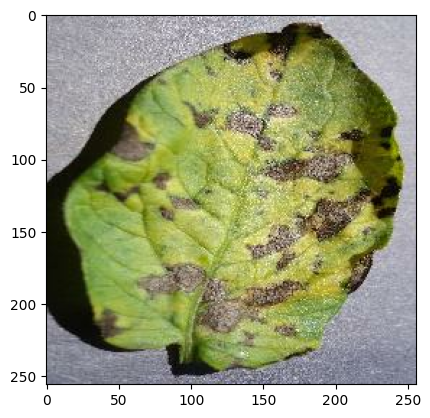

In [20]:
for img_batch, label_batch in test_ds.take(1):
  first_img = img_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('First image to predict')
  plt.imshow(first_img)
  print('Acctual label:', class_name[first_label])

  batch_predict = model.predict(img_batch)
  print('Predicted label:', class_name[np.argmax(batch_predict[0])])

In [21]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_name[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


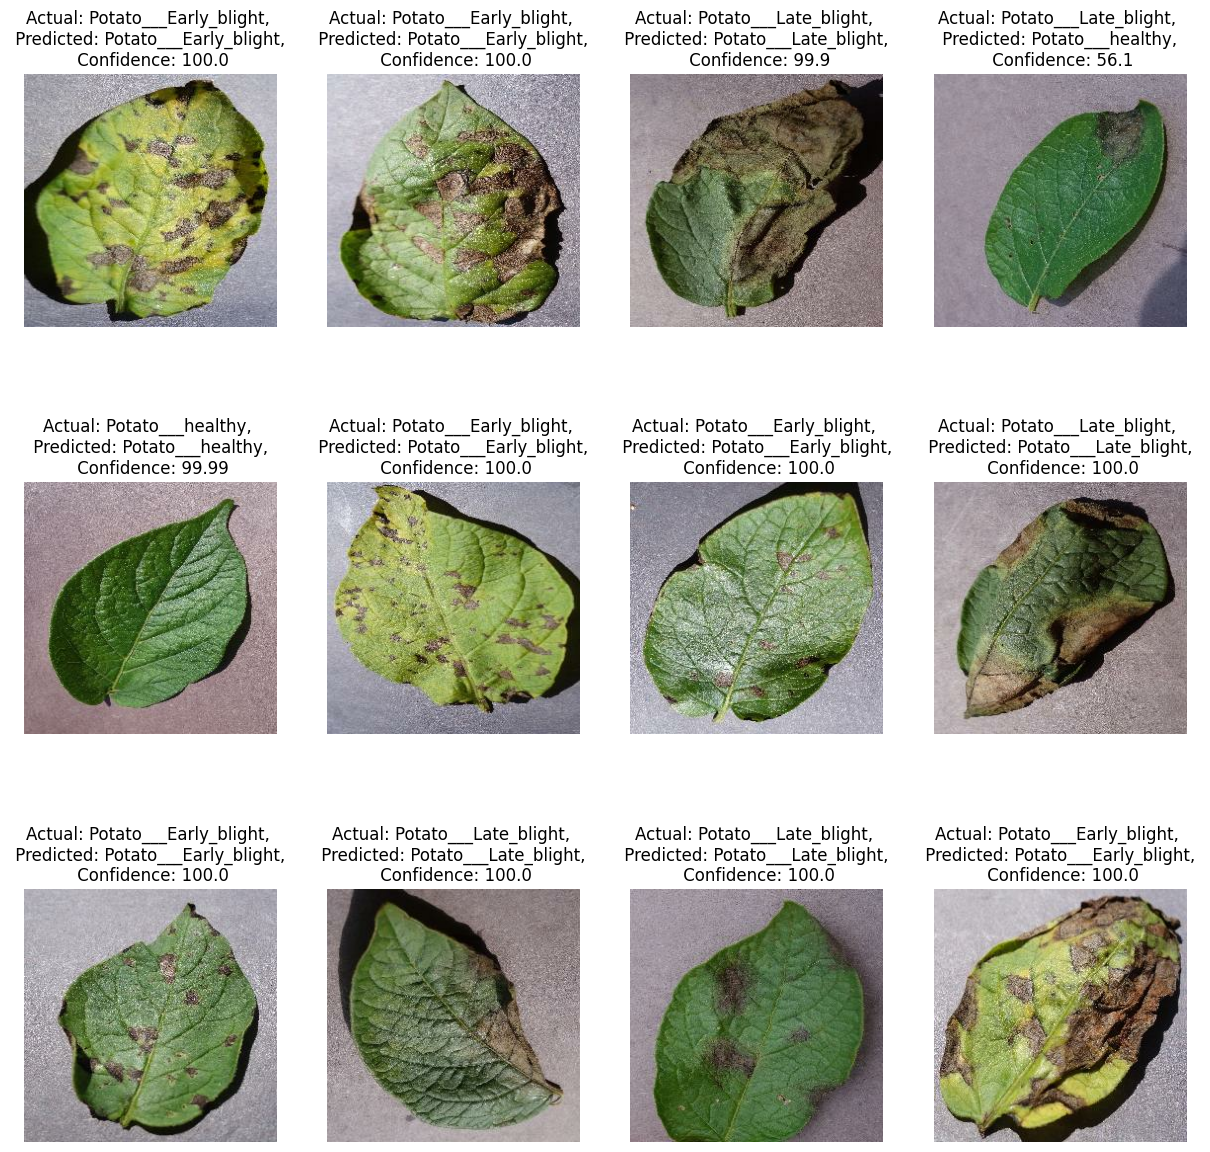

In [23]:
plt.figure(figsize=(15, 15))
for img_batch, label_batch in test_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, img_batch[i])
        actual_class = class_name[label_batch[i]]

        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}')
        plt.axis('off')

In [27]:
import os
model_version = max([int(i) for i in os.listdir('/content/model') + [0]]) + 1
model.save(f'/content/model/{model_version}')

In [31]:
!zip -r '/content/2.zip' '/content/model/2'

  adding: content/model/2/ (stored 0%)
  adding: content/model/2/variables/ (stored 0%)
  adding: content/model/2/variables/variables.index (deflated 68%)
  adding: content/model/2/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/model/2/saved_model.pb (deflated 88%)
  adding: content/model/2/assets/ (stored 0%)
  adding: content/model/2/fingerprint.pb (stored 0%)
  adding: content/model/2/keras_metadata.pb (deflated 94%)
